In [28]:
!pip -q install ucimlrepo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import keras as K
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from datetime import datetime, timedelta
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

In [2]:
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

In [3]:
data = individual_household_electric_power_consumption.data.features
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H:%M:%S')
data.set_index('datetime', inplace=True)

data.drop(['Date', 'Time'], axis=1, inplace=True)


for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')


data = data.dropna()

In [4]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
print(f"Dataset shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")

Dataset shape: (2049280, 7)
Date range: 2006-12-16 17:24:00 to 2010-11-26 21:02:00


In [6]:
data_hourly = data.resample('h').mean()

In [7]:
data = data.copy()
# Extract time-based features
data.loc[:, 'hour'] = data.index.hour
data.loc[:, 'dayofweek'] = data.index.dayofweek
data.loc[:, 'month'] = data.index.month
data.loc[:, 'dayofyear'] = data.index.dayofyear

# Calculate rolling statistics
data.loc[:, 'rolling_mean_6h'] = data['Global_active_power'].rolling(window=6).mean()
data.loc[:, 'rolling_std_6h'] = data['Global_active_power'].rolling(window=6).std()

# Calculate lag features
data.loc[:, 'lag_1h'] = data['Global_active_power'].shift(1)
data.loc[:, 'lag_24h'] = data['Global_active_power'].shift(24)
data.loc[:, 'lag_7d'] = data['Global_active_power'].shift(7 * 24)


# Drop rows with NaN values created by rolling windows and lag features
data = data.dropna()

In [8]:
features = ['Global_active_power', 'Global_reactive_power', 'Voltage',
            'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
            'Sub_metering_3', 'hour', 'dayofweek', 'month', 'dayofyear',
            'rolling_mean_6h', 'rolling_std_6h', 'lag_1h', 'lag_24h', 'lag_7d']

In [9]:
# Scale the data
scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(data[features]),
    columns=features,
    index=data.index
)

In [10]:
def create_sequences(data, seq_length):
    """Create sequences for time series prediction"""
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].values
        y = data.iloc[i + seq_length]['Global_active_power']
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [11]:
X, y = create_sequences(data_scaled)

In [ ]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 24, len(features))
X_test = X_test.reshape(X_test.shape[0], 24, len(features))

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (1639270, 24, 16)
Testing data shape: (409818, 24, 16)


In [ ]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
model = build_lstm_model((24, len(features)))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
40982/40982 ━━━━━━━━━━━━━━━━━━━━ 284s 7ms/step - loss: 0.0793 - val_loss: 0.0417
Epoch 2/50
40982/40982 ━━━━━━━━━━━━━━━━━━━━ 277s 7ms/step - loss: 0.0601 - val_loss: 0.0415
Epoch 3/50
40982/40982 ━━━━━━━━━━━━━━━━━━━━ 278s 7ms/step - loss: 0.0578 - val_loss: 0.0441
Epoch 4/50
40982/40982 ━━━━━━━━━━━━━━━━━━━━ 278s 7ms/step - loss: 0.0562 - val_loss: 0.0401
Epoch 5/50
40982/40982 ━━━━━━━━━━━━━━━━━━━━ 279s 7ms/step - loss: 0.0546 - val_loss: 0.0393
Epoch 6/50
40982/40982 ━━━━━━━━━━━━━━━━━━━━ 279s 7ms/step - loss: 0.0538 - val_loss: 0.0397
Epoch 7/50
40982/40982 ━━━━━━━━━━━━━━━━━━━━ 280s 7ms/step - loss: 0.0539 - val_loss: 0.0397
Epoch 8/50
40982/40982 ━━━━━━━━━━━━━━━━━━━━ 280s 7ms/step - loss: 0.0528 - val_loss: 0.0389
Epoch 9/50
40982/40982 ━━━━━━━━━━━━━━━━━━━━ 281s 7ms/step - loss: 0.0521 - val_loss: 0.0381
Epoch 10/50
40982/40982 ━━━━━━━━━━━━━━━━━━━━ 280s 7ms/step - loss: 0.0516 - val_loss: 0.0396
Epoch 11/50
40982/40982 ━━━━━━━━━━━━━━━━━━━━ 280s 7ms/step - loss: 0.0514 - val

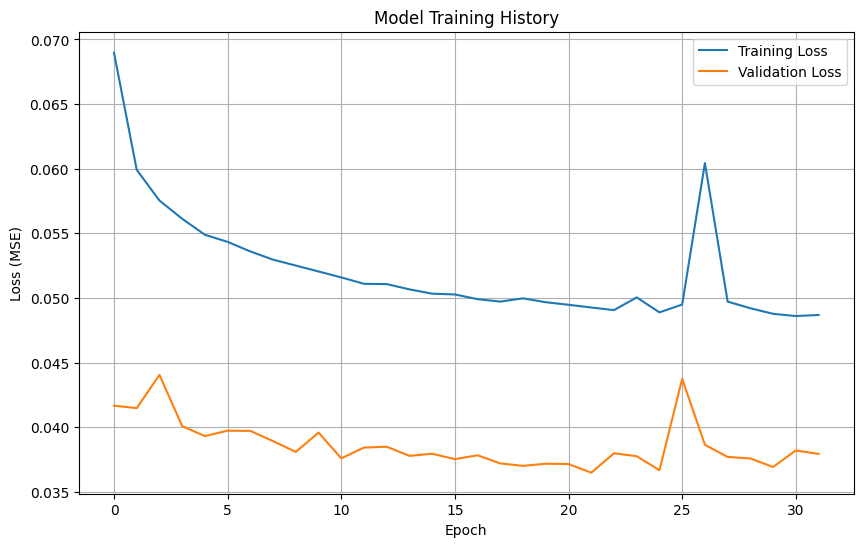

In [ ]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Make predictions
print("Making predictions...")
y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions (need to create a dummy dataframe to inverse_transform)
dummy = np.zeros((len(y_pred_scaled), len(features)))
dummy[:, 0] = y_pred_scaled.flatten()  # Global_active_power is the first column
y_pred = scaler.inverse_transform(dummy)[:, 0]

# Inverse transform the actual values
dummy = np.zeros((len(y_test), len(features)))
dummy[:, 0] = y_test  # Global_active_power is the first column
y_test_inv = scaler.inverse_transform(dummy)[:, 0]

# Evaluate model
print("Evaluating model performance...")


Making predictions...
 4148/12807 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step

In [23]:
mae = mean_absolute_error(y_test_inv, y_pred)
mse = mean_squared_error(y_test_inv, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Absolute Error (MAE): 0.0737
Root Mean Squared Error (RMSE): 0.1915
R² Score: 0.9543


In [24]:
def plot_results(actual, predicted, title='Load Forecasting Results'):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Global Active Power (kW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

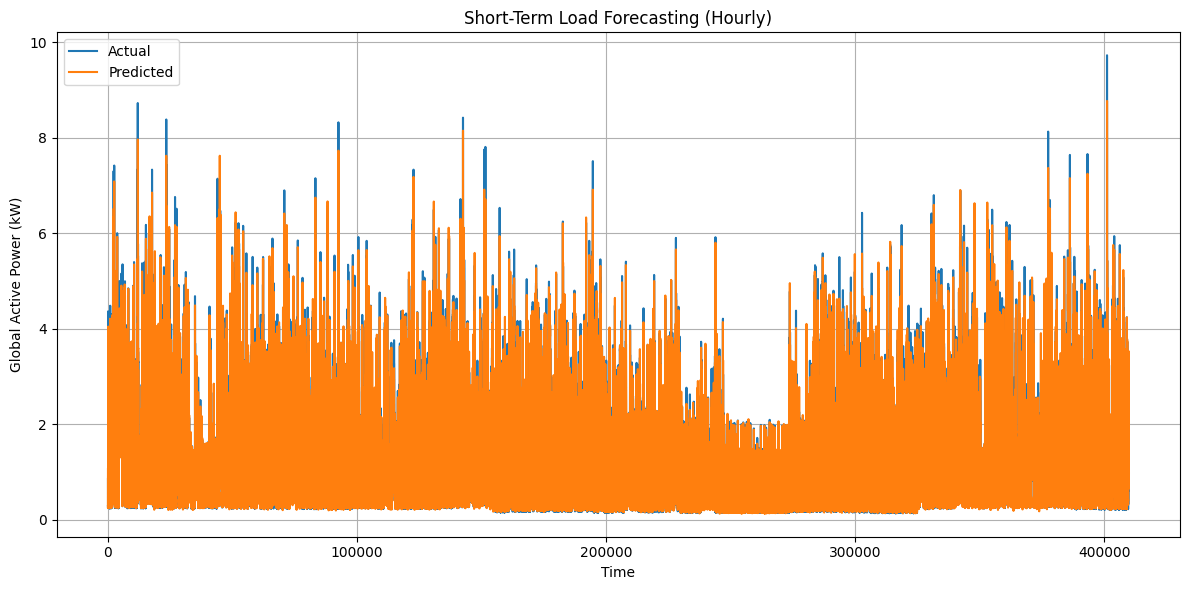

In [25]:
plot_results(y_test_inv, y_pred, 'Short-Term Load Forecasting (Hourly)')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


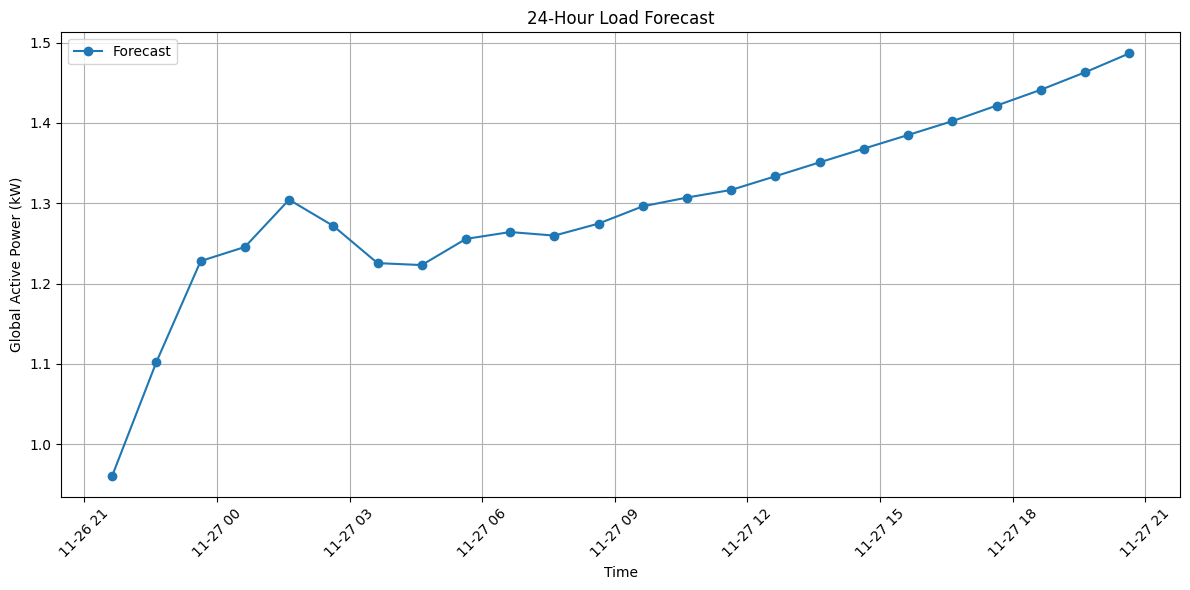

Model saved as 'load_forecasting_model.h5'


In [27]:
# Generate 24-hour forecast
last_sequence = X_test[-1].reshape(1, 24, len(features))

next_24h_predictions = []
current_sequence = last_sequence.copy()

for _ in range(24):
    # Predict the next hour
    next_hour_pred = model.predict(current_sequence)[0][0]
    next_24h_predictions.append(next_hour_pred)

    # Update the sequence for the next prediction
    new_row = current_sequence[0, 1:, :].copy()
    new_row = np.vstack([new_row, np.zeros((1, len(features)))])
    new_row[-1, 0] = next_hour_pred  # Set the predicted value
    current_sequence[0] = new_row

# Inverse transform the predictions
dummy = np.zeros((len(next_24h_predictions), len(features)))
dummy[:, 0] = next_24h_predictions  # Global_active_power is the first column
forecast = scaler.inverse_transform(dummy)[:, 0]

# Generate forecast dates
last_date = data.index[split_idx + len(y_test) - 1]
forecast_dates = [last_date + timedelta(hours=i+1) for i in range(24)]

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, forecast, label='Forecast', marker='o')
plt.title('24-Hour Load Forecast')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the model
model.save('load_forecasting_model.h5')
print("Model saved as 'load_forecasting_model.h5'")